# POD
This notebook allows to visualise POD results

In [37]:
import numpy as np              # matrix/vector and Linear algebra
from scipy import sparse        # Sparse matrices
from scipy.io import hb_read    # To read Harwell-Boeing format
from scipy.io import mmread     # To read matrix-market format
import pickle                   # For easy input/output
import matplotlib.pyplot as plt # For plots

## Parameters

In [38]:
dir_simu = 'data/' # input directory of the simulation
dir_POD = 'results/' # input dirctory of the POD results
file_U = 'U_simu.pickle' # File containing simulation data
file_POD = 'POD.pickle' # POD results
file_mass = 'Mu.hb' # mass matrix
file_interp_u = 'M_interp_u.mm' # Interpolation matrix to the cartesian mesh. Rectangular matrix not supported by hb_read. Replaced by Matrix-Marker format.
file_Duy = 'Duy.hb' # Derivation matrix of the component u in the direction y
file_Dvx = 'Dvx.hb' # Derivation matrix of the component v in the direction x
dt = 0.2 # Hard-codded simulation saving time step

## Load Data

In [39]:
# Load POD results
(lambda_POD, Phi_POD, a_POD) = pickle.load(open(dir_POD + file_POD, 'rb'))

# Get sizes
(N, N_modes) = Phi_POD.shape
(Nt, N_modes) = a_POD.shape
t = dt * np.arange(Nt)

# Mass matrix Size: (N, N) but is sparse
Mu = hb_read(dir_simu + file_mass)

# Interp matrix matrix to interpolatine on a Cartesian grid for visualisation
# Sparse, Size (N_cart, N)
M_interp_u = mmread(dir_simu + file_interp_u)
(N_cart, *rest) = M_interp_u.shape

# Derivation matrices
Duy = hb_read(dir_simu + file_Duy)
Dvx = hb_read(dir_simu + file_Dvx)

# Model info. (x,y) are the coordinates of the interpolation cartesian mesh.
(nbdof_tot, nbdof_u, nbdof_p, nbdof_li, nbdof_lw, range_u, range_p, range_li, range_lw, x, y) = pickle.load(open(dir_simu + 'Model_data.pickle', 'rb'))

## Eigenvalues

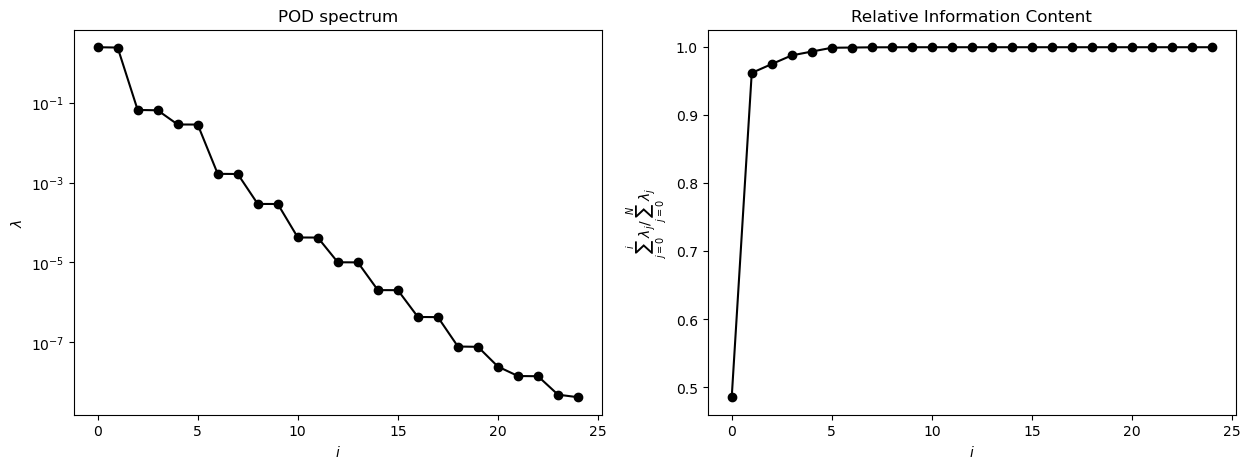

In [40]:
(fig, [ax1,ax2]) = plt.subplots(nrows=1, ncols=2, figsize=[15,5])
# POD spectrum
ax1.set_xlabel('$i$')
ax1.set_ylabel('$\lambda$')
ax1.set_title('POD spectrum')
ax1.semilogy(lambda_POD, color='black', marker='o', linestyle='solid')

# Cumulative sum: Relative Information Content (RIC)
ax2.set_title('Relative Information Content')
ax2.set_xlabel('$i$')
ax2.set_ylabel('$\sum_{j=0}^i\lambda_j/\sum_{j=0}^N\lambda_j$')
ax2.plot(np.cumsum(lambda_POD) / np.sum(lambda_POD), color='black', marker='o', linestyle='solid')

## Spatial modes

In [46]:
# Interpolate on the cartesian grid (and reshape)
Phi_interp = M_interp_u @ Phi_POD
Nc = 2
Nx = len(x)
Ny = len(y)
Phi_interp = Phi_interp.reshape((Ny, Nx, Nc, N_modes))

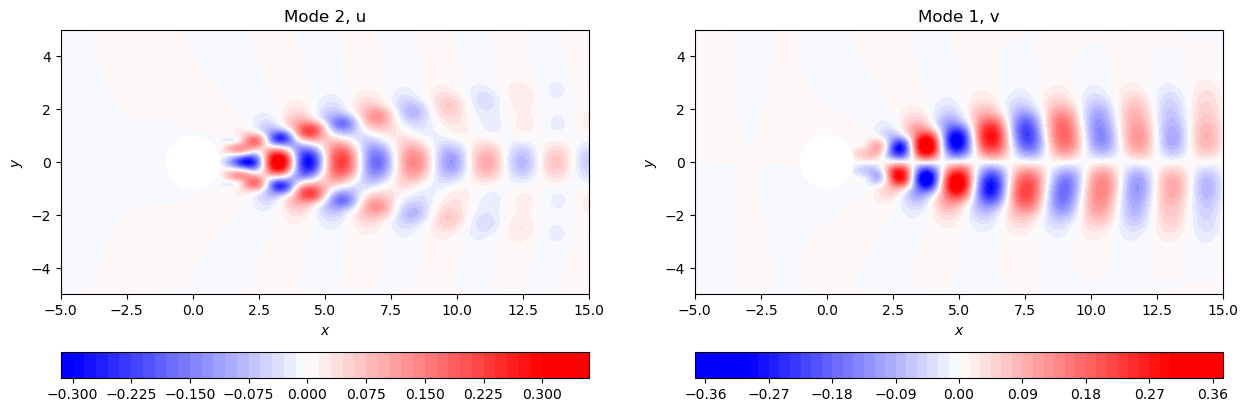

In [47]:
# Plot mode i
imode = 2

circle1 = plt.Circle((0, 0), 1.0, color='white')
circle2 = plt.Circle((0, 0), 1.0, color='white')

(fig, [ax1,ax2]) = plt.subplots(nrows=1, ncols=2, figsize=[15,5])
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_title('Mode {}, u'.format(imode))
ax1.set_aspect('equal', 'box')
pc1 = ax1.contourf(x, y, Phi_interp[:,:,0,imode], cmap = 'bwr', levels = 50, vmin = -0.3, vmax=0.3)
fig.colorbar(pc1, ax=ax1, location='bottom')
ax1.add_patch(circle1)

ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title('Mode 1, v')
ax2.set_aspect('equal', 'box')
pc2 = ax2.contourf(x, y, Phi_interp[:,:,1,imode], cmap = 'bwr', levels = 50, vmin = -0.3, vmax=0.3)
fig.colorbar(pc2, ax=ax2, location='bottom')
ax2.add_patch(circle2)

In [48]:
# Build vorticity of the modes
dPhiudy = sparse.linalg.spsolve(Mu, Duy @ Phi_POD)
dPhivdx = sparse.linalg.spsolve(Mu, Dvx @ Phi_POD)
dPhiudy_interp = M_interp_u @ dPhiudy
dPhivdx_interp = M_interp_u @ dPhivdx
dPhiudy_interp = dPhiudy_interp.reshape((Ny, Nx, Nc, N_modes))
dPhivdx_interp = dPhivdx_interp.reshape((Ny, Nx, Nc, N_modes))
Phi_vort = dPhivdx_interp[:,:,1,:] - dPhiudy_interp[:,:,0,:]

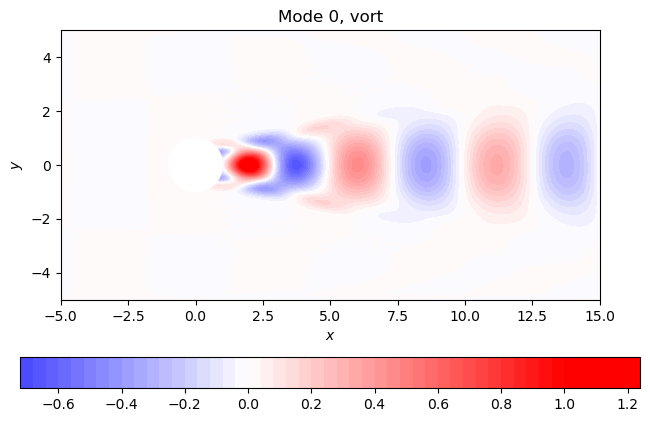

In [49]:
# Plot vorticity of the modes
imode = 0

circle = plt.Circle((0, 0), 1.0, color='white')
(fig, ax1) = plt.subplots(nrows=1, ncols=1, figsize=[8,5])
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_title('Mode {}, vort'.format(imode))
ax1.set_aspect('equal', 'box')
pc1 = ax1.contourf(x, y, Phi_vort[:,:,imode], cmap = 'bwr', levels = 50, vmin=-1., vmax=1.)
fig.colorbar(pc1, ax=ax1, location='bottom')
ax1.add_patch(circle)

## Temporal modes

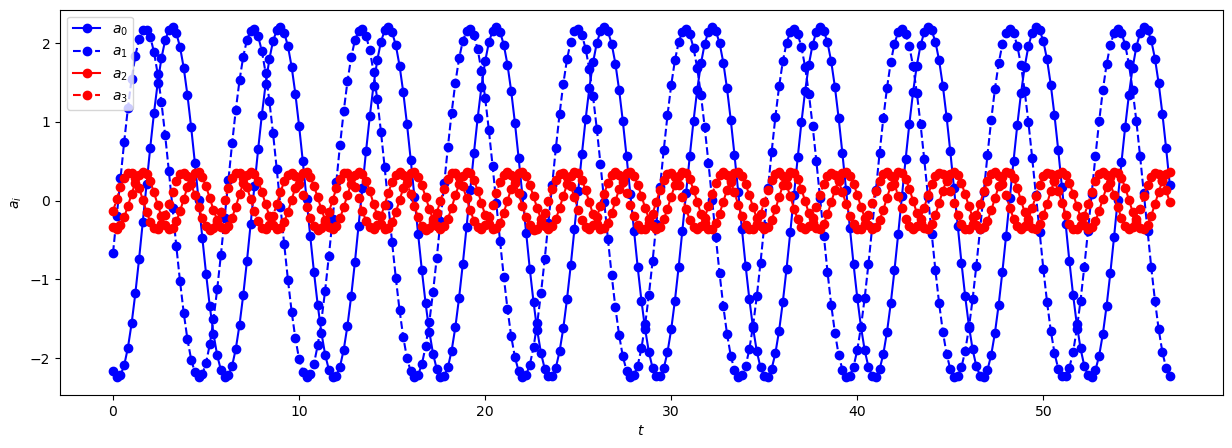

In [50]:
# Plot 4 first temporal modes. imode_0 allows to discard eventually the first mode (if there is a shift-mode)
imode_0 = 0
(fig, ax1) = plt.subplots(nrows=1, ncols=1, figsize=[15,5])
ax1.plot(t, a_POD[:,imode_0+0], color = 'blue', marker = 'o', linestyle='solid' )
ax1.plot(t, a_POD[:,imode_0+1], color = 'blue', marker = 'o', linestyle='dashed')
ax1.plot(t, a_POD[:,imode_0+2], color = 'red' , marker = 'o', linestyle='solid' )
ax1.plot(t, a_POD[:,imode_0+3], color = 'red' , marker = 'o', linestyle='dashed')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$a_i$')
ax1.legend(['$a_{}$'.format(imode_0),'$a_{}$'.format(imode_0+1), '$a_{}$'.format(imode_0+2), '$a_{}$'.format(imode_0+3)])

Reconstruction

In [63]:
# Parameters
Nr = 6
it = 10

Ir = slice(0, Nr)

In [64]:
# Load data
(t, U_tot) = pickle.load(open(dir_simu + file_U, 'rb'))
Um = np.mean(U_tot, axis=1)
u = U_tot - np.tile(Um[:,np.newaxis], (1, Nt))

u_interp = M_interp_u @ u
u_interp = u_interp.reshape((Ny, Nx, Nc, Nt))

In [65]:
# Reconstruct fluctuation
u_reconstruct = Phi_POD[:,Ir] @ a_POD[:,Ir].T

u_rec_interp = M_interp_u @ u_reconstruct
u_rec_interp = u_rec_interp.reshape((Ny, Nx, Nc, Nt))

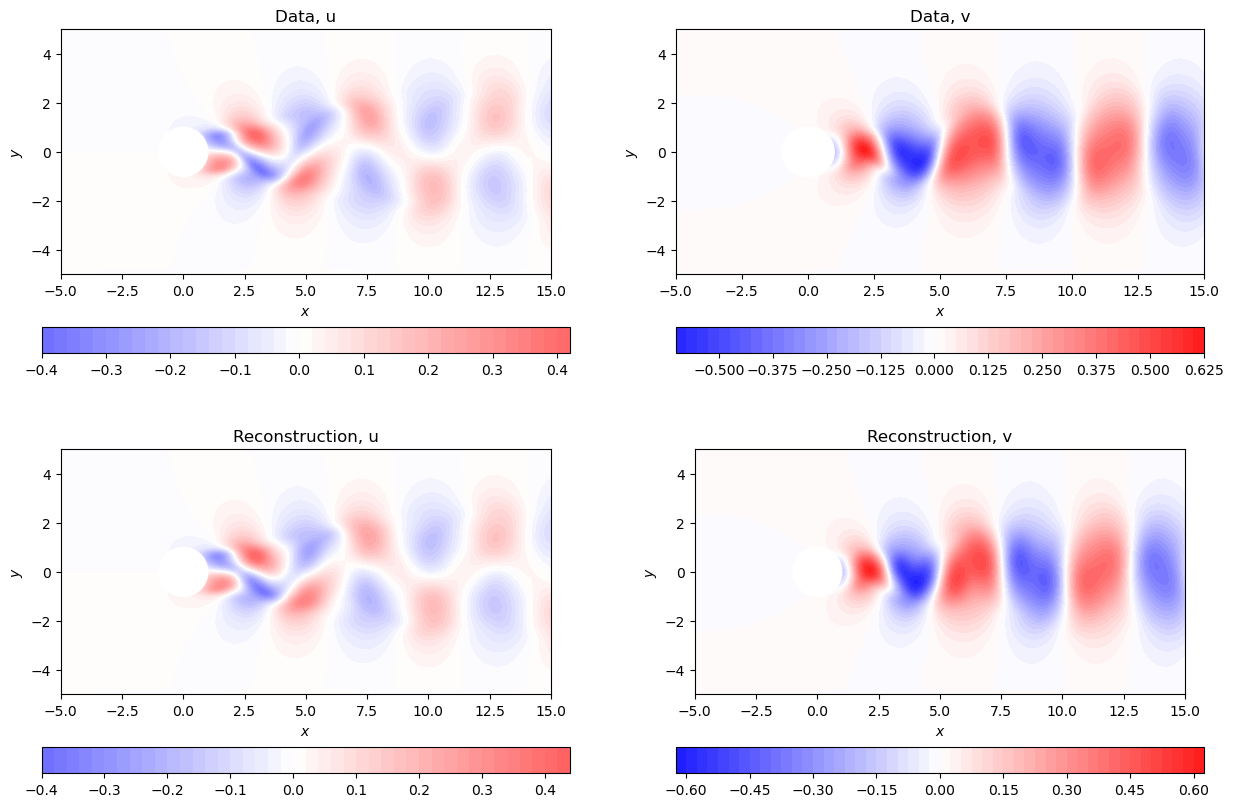

In [66]:
# Plot
circle_r1 = plt.Circle((0, 0), 1.0, color='white')
circle_r2 = plt.Circle((0, 0), 1.0, color='white')
circle_r3 = plt.Circle((0, 0), 1.0, color='white')
circle_r4 = plt.Circle((0, 0), 1.0, color='white')

(fig, [[ax1, ax2], [ax3, ax4]]) = plt.subplots(nrows=2, ncols=2, figsize=[15,10])
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_title('Data, u')
ax1.set_aspect('equal', 'box')
pc1 = ax1.contourf(x, y, u_interp[:,:,0,it], cmap = 'bwr', levels = 50, vmin = -0.7, vmax=0.7)
fig.colorbar(pc1, ax=ax1, location='bottom')
ax1.add_patch(circle_r1)

ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title('Data, v')
ax1.set_aspect('equal', 'box')
pc2 = ax2.contourf(x, y, u_interp[:,:,1,it], cmap = 'bwr', levels = 50, vmin = -0.7, vmax=0.7)
fig.colorbar(pc2, ax=ax2, location='bottom')
ax2.add_patch(circle_r2)

ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
ax3.set_title('Reconstruction, u')
ax3.set_aspect('equal', 'box')
pc3 = ax3.contourf(x, y, u_rec_interp[:,:,0,it], cmap = 'bwr', levels = 50, vmin = -0.7, vmax=0.7)
fig.colorbar(pc3, ax=ax3, location='bottom')
ax3.add_patch(circle_r3)

ax4.set_xlabel('$x$')
ax4.set_ylabel('$y$')
ax4.set_title('Reconstruction, v')
ax4.set_aspect('equal', 'box')
pc4 = ax4.contourf(x, y, u_rec_interp[:,:,1,it], cmap = 'bwr', levels = 50, vmin = -0.7, vmax=0.7)
fig.colorbar(pc4, ax=ax4, location='bottom')
ax4.add_patch(circle_r4)
